In [1]:
# Load needed packages
import numpy as np
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.palettes as palette # For palette of colors
import math
from scipy import stats
from matplotlib import rc
import ROOT 

# Latex rendering for plotting
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

# Define color palette
col = palette.brewer['RdYlBu'][10] #(8)

# Convert HTML color code to RGB
from PIL import ImageColor
ImageColor.getcolor(col[9], "RGB")

# Define folder to save plots
dir_name = './plots_arduino'
if not os.path.isdir(dir_name):
    os.mkdir(dir_name)

Welcome to JupyROOT 6.22/02


<ipython-input-1-eeb118f643f9>:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\boldmath']


## Load Arduino data

In [2]:
# DOCUMENTATION:
# Tcf  = temperature of cold finger
# Vout = output of amplifier circuit

# Load arduino datasets

path_co_ard = 'Data_arduino/cooling_ard.dat'
path_he_ard = 'Data_arduino/heating_ard.dat'

col_name = ['Tcf','Vout']

df_co_ard = pd.read_csv(path_co_ard, sep="\t", header=None, names=col_name,skiprows=4)
df_he_ard = pd.read_csv(path_he_ard, sep="\t", header=None, names=col_name,skiprows=4)

# Convert Vout arduino dataset from V to mV
df_co_ard['Vout'] = df_co_ard['Vout']*1e3
df_he_ard['Vout'] = df_he_ard['Vout']*1e3


# Group-by the same temperature
df_co_ard_filt = df_co_ard.groupby(['Tcf'], as_index=False).agg(
                      {'Vout':['mean','sem']})
df_he_ard_filt = df_he_ard.groupby(['Tcf'], as_index=False).agg(
                      {'Vout':['mean','sem']})

# Check if NaN are present
#is_nan = df_co_ard_filt.isnull()
#row_nan = is_nan.any(axis=1)
#rows_with_nan = df_co_ard_filt[row_nan]

err_Vout = 5/np.sqrt(12)

# Replace NaN with Arduino precision
df_co_ard_filt = df_co_ard_filt.replace(np.nan,err_Vout)
df_he_ard_filt = df_he_ard_filt.replace(np.nan,err_Vout)

df_co_ard_filt.describe()

Tcf        Vout            
                         mean         sem
count  688.000000  688.000000  688.000000
mean   153.212064  310.578155    2.644648
std     57.829138   71.673452    2.322272
min     53.263000  150.000000    0.000000
25%    103.288750  257.705357    1.443376
50%    153.315500  334.650000    2.041241
75%    203.052500  371.208333    3.167651
max    253.079000  400.500000   27.000000

## Plot arduino data 

### Temporal evolution of cold finger temperature

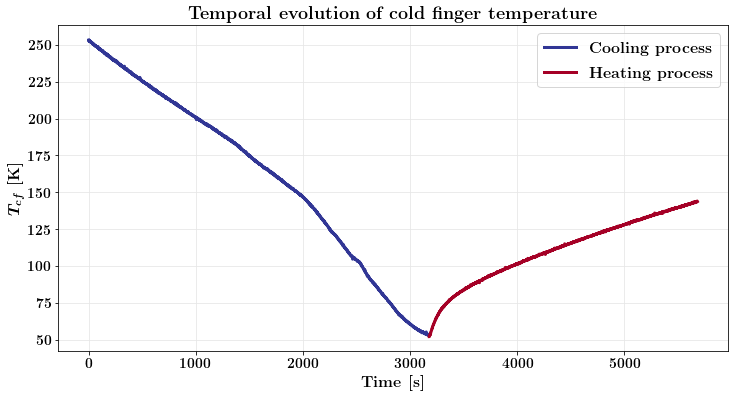

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax.plot(df_co_ard['Tcf'].index,df_co_ard['Tcf'],'-',color=col[0],linewidth=3,label=r'\bf{Cooling process}')
ax.plot(df_he_ard['Tcf'].index+3179,df_he_ard['Tcf'],'-',color=col[9],linewidth=3,label=r'\bf{Heating process}')

ax.set_title(r'\bf{Temporal evolution of cold finger temperature}', fontsize=18)
ax.set_ylabel(r'\bf{$T_{cf}$ [K]}',fontsize=16)
ax.set_xlabel(r'\bf{Time [s]}',fontsize=16)
ax.grid(color='0.9')
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
#ax.set_xlim(0,3179+2504)
plt.legend(loc='best',fontsize=16)
ax.set_axisbelow(True)

dir_name = './plots_arduino'
if not os.path.isdir(dir_name):
    os.mkdir(dir_name)

plt.savefig(dir_name+'/temporal_evolution_cold_finger.pdf', format='pdf',bbox_inches = "tight")
#plt.close()

### Plot of arduino averaged data

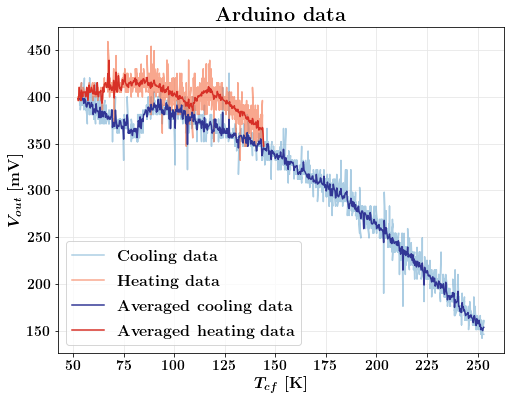

In [4]:
# Plot of dataset

fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(df_co_ard['Tcf'],df_co_ard['Vout'],color=col[2],label=r'\bf{Cooling data}',alpha=0.6)
ax.plot(df_he_ard['Tcf'],df_he_ard['Vout'],color=col[7],label=r'\bf{Heating data}',alpha=0.6)
ax.plot(df_co_ard_filt['Tcf'],df_co_ard_filt['Vout']['mean'],color=col[0],label=r'\bf{Averaged cooling data}')
ax.plot(df_he_ard_filt['Tcf'],df_he_ard_filt['Vout']['mean'],color=col[8],label=r'\bf{Averaged heating data}')

ax.set_title(r'\bf{Arduino data}', fontsize=20)
ax.set_xlabel(r'\bf{$T_{cf}$ [K]}',fontsize=16)
ax.set_ylabel(r'\bf{$ V_{out}$ [mV]}',fontsize=16)
ax.grid(color='0.9')
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
plt.legend(loc='lower left',fontsize=16)
ax.set_axisbelow(True)

plt.savefig(dir_name+'/arduino_data.pdf', format='pdf',bbox_inches = "tight")

In [5]:
# Find minimum (TRIALS)

def minimum_Tc(data,minimum,maximum):
    
    df = data[data['Tcf']>minimum]
    df = df[df['Tcf']<maximum]

    indx_min = np.argmin(df['Vout']['mean'])
    Tc_min = [df.iloc[indx_min]['Tcf'],df.iloc[indx_min]['Vout']['mean']]
    
    print(Tc_min)
    return(Tc_min)
    
Tc_min_co = minimum_Tc(df_co_ard_filt,75,95)

Tc_min_he = minimum_Tc(df_he_ard_filt,100,120)

[    81.642
Name: 98, dtype: float64, 356.3333333333333]
[    109.153
Name: 190, dtype: float64, 385.0]


### Tc estimate for heating and cooling

In [6]:
# Function for finding interception between two lines
def interception(param1,param2,string1='',string2='',cov_param1=0,cov_param2=0):
        
    # a + b x
    a, erra = param1[0]
    b, errb = param1[1]
    
    # c + d x
    c, errc = param2[0]
    d, errd = param2[1]  
    
    x = (a-c)/(d-b)
    y = a + b * x
    
    errx = np.sqrt( (1/(d-b) * erra)**2 + ( (a-c)/(d-b)**2 * errb )**2 +
                     (-1/(d-b) * errc)**2 + (-(a-c)/(d-b)**2 * errd)**2 -
                    2*(a-c)/((d-b)**3) * (cov_param1-cov_param2) )
 
    erry = np.sqrt( erra**2 + (x*errb)**2 + (b*errx)**2 )
    
    xx = [x,errx]
    yy = [y,erry]

    #print('Linear fit a+bx: '+string1)
    #print('a=',a,'+-',erra)
    #print('b=',b,'+-',errb,'\n')

    #print('Linear fit c+dx: '+string2)
    #print('c=',c,'+-',errc)
    #print('d=',d,'+-',errd,'\n')
    
    print('-------------------------------------------','\n')
    print('Interception:')
    print('xp=',xx[0],'+-',xx[1])
    print('yp=',yy[0],'+-',yy[1],'\n')
    print('-------------------------------------------','\n')
    
    return xx, yy


------------------------------------------- 

a:  452.9142648722292 +- 2.9345267936489883
b:  -1.1149128165290185 +- 0.04224111028731697 

Chi2:  198.32684036262998
Ndf :  61
Cov_ab:  -0.1235713286824556
Pearson coefficient:  (-0.845278104045184, 1.8629451391400772e-20) 

-------------------------------------------
------------------------------------------- 

a:  99.40890773504775 +- 22.007203093412677
b:  3.2876386690543393 +- 0.2584147754163525 

Chi2:  90.35830464677618
Ndf :  17
Cov_ab:  -5.685795065833491
Pearson coefficient:  (0.8960893771610914, 1.40216941093197e-09) 

-------------------------------------------
------------------------------------------- 

Interception:
xp= 80.29556458221417 +- 1.4673560171590856
yp= 363.3917108090851 +- 4.774095519943693 

------------------------------------------- 



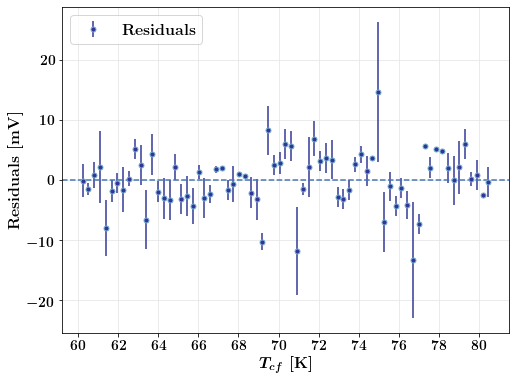

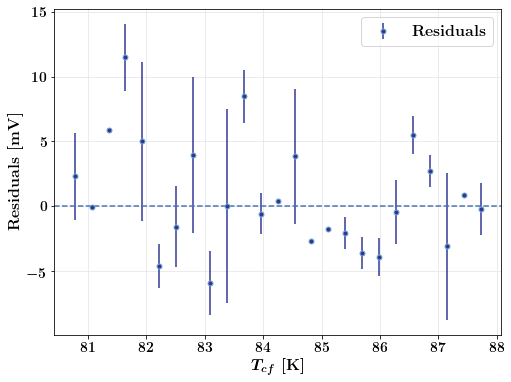

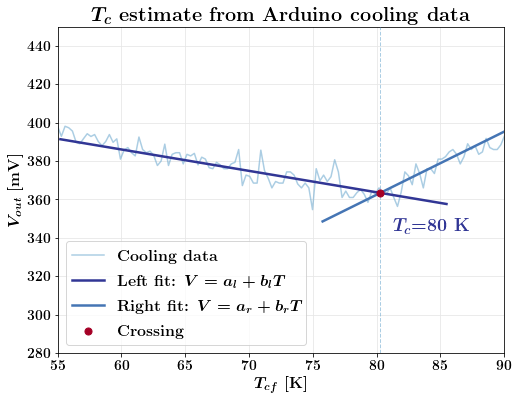


****************************************
Minimizer is Linear / Migrad
Chi2                      =      198.327
NDf                       =           61
p0                        =      452.914   +/-   2.93453     
p1                        =     -1.11491   +/-   0.0422411   

****************************************
Minimizer is Linear / Migrad
Chi2                      =      90.3583
NDf                       =           17
p0                        =      99.4089   +/-   22.0072     
p1                        =      3.28764   +/-   0.258415    


In [7]:
def tc_estimate_co(data,range_fit_left,range_fit_right,par_guess_left=[0,0],par_guess_right=[0,0]):

    def linear_fit(x,y,errx,erry,par_guess=[0,0]):

        
        f = ROOT.TF1("f", "pol1") # Define linear fit model
        
        g = ROOT.TGraphErrors(x.size, x.astype(np.double), y.astype(np.double), 
                              errx.astype(np.double), erry.astype(np.double))
        
        f.SetParameters(par_guess[0],par_guess[1]) # Set initial parameters
        fit = g.Fit('f','S',"")                    # Perform fit
      
        cov_ab = fit.GetCovarianceMatrix()[1,0] # Compute covariance term ab
        pcoeff = stats.pearsonr(x, y)           # Compute Pearson coefficient
        
        
        print('-------------------------------------------','\n')
        print('a: ', f.GetParameter(0),'+-',f.GetParError(0))
        print('b: ', f.GetParameter(1),'+-',f.GetParError(1),'\n')
        print('Chi2: ', f.GetChisquare())
        print('Ndf : ', f.GetNDF()      )
        print('Cov_ab: ',cov_ab)
        print('Pearson coefficient: ', pcoeff,'\n')
        
        print('-------------------------------------------')

        x_fit     = np.linspace(x[0]-5, x[-1]+5, 300)
        y_fit     = f.GetParameter(0) + f.GetParameter(1)*x_fit
        y_fit_res = f.GetParameter(0) + f.GetParameter(1)*x
        
        intercept = [f.GetParameter(0),f.GetParError(0)]
        slope     = [f.GetParameter(1),f.GetParError(1)]

        res = (y_fit_res - y)
        err_res = erry
        
        return(x_fit,y_fit,intercept,slope,res,err_res,cov_ab)    
        
        
    # Filter left data by given range
    minimum = range_fit_left[0]
    maximum = range_fit_left[1]
    
    df = data[data['Tcf']>minimum]
    df = df[df['Tcf']<maximum]
    
    x_l = np.array(df['Tcf'])
    y_l = np.array(df['Vout']['mean'])
    erry_l = np.array(df['Vout']['sem'])

    # Filter right data by given range
    minimum = range_fit_right[0]
    maximum = range_fit_right[1]
    
    df = data[data['Tcf']>minimum]
    df = df[df['Tcf']<maximum]

    x_r = np.array(df['Tcf'])
    y_r = np.array(df['Vout']['mean'])
    erry_r = np.array(df['Vout']['sem'])
    
    
    # Perform linear fit for right and left hand
    x_fit_l, y_fit_l, intercept_l, slope_l, res_l, err_res_l, cov_ab_l = linear_fit(x_l,y_l,np.zeros(x_l.shape[0]),erry_l,par_guess_left)
    x_fit_r, y_fit_r, intercept_r, slope_r, res_r, err_res_r, cov_ab_r = linear_fit(x_r,y_r,np.zeros(x_r.shape[0]),erry_r,par_guess_right)
    
    
    # Find intersection point
    xp, yp = interception([intercept_l,slope_l],[intercept_r,slope_r],'left','right',cov_ab_l,cov_ab_r)
    
    
    # PLOT RESULTS
    
    
    # Plot left residuals
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(x_l,res_l,yerr=err_res_l,fmt='o',markerfacecolor=col[0],
                    color=col[2],ecolor=col[0],label=r'\bf{Residuals}',alpha=1,markersize=5)
    ax.axhline(0,color=col[1],ls='--')
    ax.set_xlabel(r'\bf{$T_{cf}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{Residuals [mV]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='upper left',fontsize=16)
    ax.set_xticks(np.arange(60, 81, 2))
    ax.set_axisbelow(True)
    plt.savefig(dir_name+'/ard_res_left_co.pdf', format='pdf',bbox_inches = "tight")
        
    
    # Plot right residuals
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(x_r,res_r,yerr=err_res_r,fmt='o',markerfacecolor=col[0],
                    color=col[2],ecolor=col[0],label=r'\bf{Residuals}',alpha=1,markersize=5)
    ax.axhline(0,color=col[1],ls='--')
    ax.set_xlabel(r'\bf{$T_{cf}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{Residuals [mV]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='upper right',fontsize=16)
    ax.set_xticks(np.arange(81, 89, 1))
    ax.set_axisbelow(True)
    plt.savefig(dir_name+'/ard_res_right_co.pdf', format='pdf',bbox_inches = "tight")
    
    
    # Plot tc estimate method
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    ax.plot(data['Tcf'],data['Vout']['mean'],color=col[2],label=r'\bf{Cooling data}',alpha=0.6,zorder=1)
    
    label_fit = r'\bf{Left fit: $V=a_l+b_l T$}'
    ax.plot(x_fit_l,y_fit_l,color=col[0],linewidth=2.5,label=label_fit,zorder=2)
    
    label_fit = r'\bf{Right fit: $V=a_r+b_r T$}'
    ax.plot(x_fit_r,y_fit_r,color=col[1],linewidth=2.5,label=label_fit,zorder=2)
    
    ax.axvline(xp[0],color=col[2],alpha=0.6,ls='--',linewidth=1,zorder=5)
    ax.scatter(xp[0],yp[0],color=col[9],ec=col[9],marker='o',s=50,zorder=6,label=r'\bf{Crossing}')

    ax.set_title(r'\bf{$T_c$ estimate from Arduino cooling data}', fontsize=20)
    ax.set_xlabel(r'\bf{$T_{cf}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{$V_{out}$ [mV]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='best',fontsize=16)
    ax.set_xlim(55,90)
    ax.set_ylim(280,450)
    ax.set_axisbelow(True)
    #plt.text(xp[0]+1,yp[0]-20,r'$T_c$={: 2.1f} K'.format(xp[0]),color=col[0],fontsize=18)
    plt.text(xp[0]+1,yp[0]-20,r'\bf{$T_c$=80 K}',color=col[0],fontsize=18)
    plt.savefig(dir_name+'/ard_est_co.pdf', format='pdf',bbox_inches = "tight")
    


# Define cooling range
xmin_l = 60
xmax_l = 80.5
xmin_r = 80.5
xmax_r = 88

# Compute Tc
tc_estimate_co(df_co_ard_filt,[xmin_l,xmax_l],[xmin_r,xmax_r],[100,-2],[100,2])


------------------------------------------- 

a:  521.3146844323823 +- 4.860649945610764
b:  -1.1932321756665925 +- 0.04930703487149701 

Chi2:  54.72312224018964
Ndf :  57
Cov_ab:  -0.2393833086364912
Pearson coefficient:  (-0.9400163241416806, 2.6570174776417754e-28) 

-------------------------------------------
------------------------------------------- 

a:  173.30892106173278 +- 10.30742745428973
b:  2.0133996475617653 +- 0.09171926276172863 

Chi2:  47.81322816253723
Ndf :  33
Cov_ab:  -0.945054967775204
Pearson coefficient:  (0.9146143685755329, 1.5774375950313185e-14) 

-------------------------------------------
------------------------------------------- 

Interception:
xp= 108.52688507915008 +- 3.1866688452573317
yp= 391.81691323106975 +- 8.168177489806727 

------------------------------------------- 



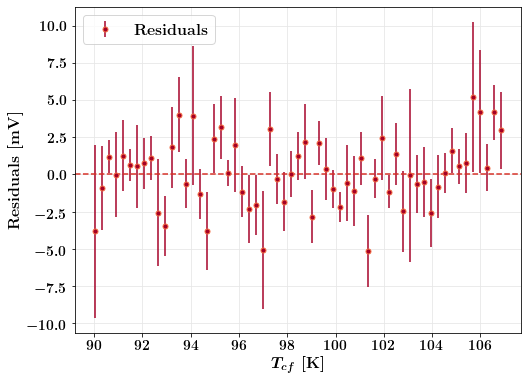

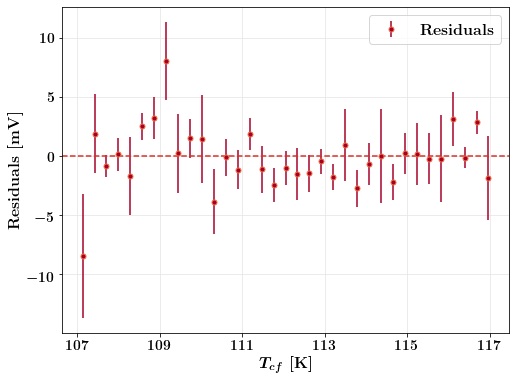

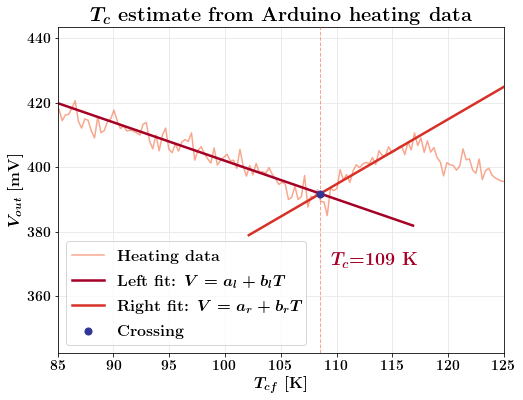


****************************************
Minimizer is Linear / Migrad
Chi2                      =      54.7231
NDf                       =           57
p0                        =      521.315   +/-   4.86065     
p1                        =     -1.19323   +/-   0.049307    

****************************************
Minimizer is Linear / Migrad
Chi2                      =      47.8132
NDf                       =           33
p0                        =      173.309   +/-   10.3074     
p1                        =       2.0134   +/-   0.0917193   


In [8]:
def tc_estimate_he(data,range_fit_left,range_fit_right,par_guess_left=[0,0],par_guess_right=[0,0]):

    
    def linear_fit(x,y,errx,erry,par_guess=[0,0]):

        
        f = ROOT.TF1("f", "pol1") # Define linear fit model
        
        g = ROOT.TGraphErrors(x.size, x.astype(np.double), y.astype(np.double), 
                              errx.astype(np.double), erry.astype(np.double))
        
        f.SetParameters(par_guess[0],par_guess[1]) # Set initial parameters
        fit = g.Fit('f','S',"")                    # Perform fit
      
        cov_ab = fit.GetCovarianceMatrix()[1,0] # Compute covariance term ab
        pcoeff = stats.pearsonr(x, y)           # Compute Pearson coefficient
        
        
        print('-------------------------------------------','\n')
        print('a: ', f.GetParameter(0),'+-',f.GetParError(0))
        print('b: ', f.GetParameter(1),'+-',f.GetParError(1),'\n')
        print('Chi2: ', f.GetChisquare())
        print('Ndf : ', f.GetNDF()      )
        print('Cov_ab: ',cov_ab)
        print('Pearson coefficient: ', pcoeff,'\n')
        
        print('-------------------------------------------')

        x_fit     = np.linspace(x[0]-5, x[-1]+10, 300)
        y_fit     = f.GetParameter(0) + f.GetParameter(1)*x_fit
        y_fit_res = f.GetParameter(0) + f.GetParameter(1)*x
        
        intercept = [f.GetParameter(0),f.GetParError(0)]
        slope     = [f.GetParameter(1),f.GetParError(1)]

        res = (y_fit_res - y)
        err_res = erry
        
        return(x_fit,y_fit,intercept,slope,res,err_res,cov_ab)  
    
        
    # Filter left data by given range
    minimum = range_fit_left[0]
    maximum = range_fit_left[1]
    
    df = data[data['Tcf']>minimum]
    df = df[df['Tcf']<maximum]
    
    x_l = np.array(df['Tcf'])
    y_l = np.array(df['Vout']['mean'])
    erry_l = np.array(df['Vout']['sem'])

    # Filter right data by given range
    minimum = range_fit_right[0]
    maximum = range_fit_right[1]
    
    df = data[data['Tcf']>minimum]
    df = df[df['Tcf']<maximum]

    x_r = np.array(df['Tcf'])
    y_r = np.array(df['Vout']['mean'])
    erry_r = np.array(df['Vout']['sem'])
    
    
    # Perform linear fit for right and left hand
    x_fit_l, y_fit_l, intercept_l, slope_l, res_l, err_res_l, cov_ab_l = linear_fit(x_l,y_l,np.zeros(x_l.shape[0]),erry_l,par_guess_left)
    x_fit_r, y_fit_r, intercept_r, slope_r, res_r, err_res_r, cov_ab_r = linear_fit(x_r,y_r,np.zeros(x_r.shape[0]),erry_r,par_guess_right)
    
    
    # Find intersection point
    xp, yp = interception([intercept_l,slope_l],[intercept_r,slope_r],'left','right',cov_ab_l,cov_ab_r)
    
    
    # PLOT RESULTS
    
    
    # Plot left residuals
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(x_l,res_l,yerr=err_res_l,fmt='o',markerfacecolor=col[9],
                    color=col[7],ecolor=col[9],label=r'\bf{Residuals}',alpha=1,markersize=5)
    ax.axhline(0,color=col[8],ls='--')
    ax.set_xlabel(r'\bf{$T_{cf}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{Residuals [mV]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='upper left',fontsize=16)
    ax.set_xticks(np.arange(90, 108, 2))
    ax.set_axisbelow(True)
    plt.savefig(dir_name+'/ard_res_left_he.pdf', format='pdf',bbox_inches = "tight")
    
    
    # Plot right residuals
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(x_r,res_r,yerr=err_res_r,fmt='o',markerfacecolor=col[9],
                    color=col[7],ecolor=col[9],label=r'\bf{Residuals}',alpha=1,markersize=5)
    ax.axhline(0,color=col[8],ls='--')
    ax.set_xlabel(r'\bf{$T_{cf}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{Residuals [mV]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='upper right',fontsize=16)
    ax.set_xticks(np.arange(107, 118, 2))
    ax.set_axisbelow(True)
    plt.savefig(dir_name+'/ard_res_right_he.pdf', format='pdf',bbox_inches = "tight")
    
    
    # Plot tc estimate method
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
        
    ax.plot(data['Tcf'],data['Vout']['mean'],color=col[7],label=r'\bf{Heating data}',alpha=0.6,zorder=1)
    
    label_fit = r'\bf{Left fit: $V=a_l+b_l T$}'
    ax.plot(x_fit_l,y_fit_l,color=col[9],linewidth=2.5,label=label_fit,zorder=2)
    
    label_fit = r'\bf{Right fit: $V=a_r+b_r T$}'
    ax.plot(x_fit_r,y_fit_r,color=col[8],linewidth=2.5,label=label_fit,zorder=2)
    
    ax.axvline(xp[0],color=col[7],alpha=0.6,ls='--',linewidth=1,zorder=5)
    ax.scatter(xp[0],yp[0],color=col[0],ec=col[0],marker='o',s=50,zorder=6,label=r'\bf{Crossing}')

    ax.set_title(r'\bf{$T_c$ estimate from Arduino heating data}', fontsize=20)
    ax.set_xlabel(r'\bf{$T_{cf}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{$V_{out}$ [mV]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='best',fontsize=16)
    ax.set_xlim(85,125)
    ax.set_axisbelow(True)
    #plt.text(xp[0]+1,yp[0]-20,r'$T_c$={: 2.1f} K'.format(xp[0]),color=col[0],fontsize=18)
    plt.text(xp[0]+1,yp[0]-22,r'\bf{$T_c$=109 K}',color=col[9],fontsize=18)
    plt.savefig(dir_name+'/ard_est_he.pdf', format='pdf',bbox_inches = "tight")
    

# Define cooling range
xmin_l = 90
xmax_l = 107
xmin_r = 107
xmax_r = 117

# Compute Tc
tc_estimate_he(df_he_ard_filt,[xmin_l,xmax_l],[xmin_r,xmax_r],[100,-2],[100,2])


## Chi square analysis

In [78]:
from scipy.stats import chi2

# interpret test-statistic

dof = 2
chi = 0.0077
prob = 0.95

critical = chi2.ppf(prob, dof)

print('Theory:',critical,'at',prob*100,'%')
print('Experimental:',chi,'\n')


if abs(chi) >= critical:
    print('Dependent (reject H0)\n')
else:
    print('Independent (fail to reject H0)','\n')

p_val = 1 - chi2.cdf(chi, dof)
print('P-value:',p_val)
print('1-P-value:',1-p_val,'\n')

# interpret p-value
alpha = 1.0 - prob
if p_val <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    

Theory: 5.991464547107979 at 95.0 %
Experimental: 0.0077 

Independent (fail to reject H0) 

P-value: 0.9961574017480432
1-P-value: 0.0038425982519567636 

Independent (fail to reject H0)
